In [132]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [133]:
df = pd.read_csv('../DATA/lending_club_loan_two.csv')


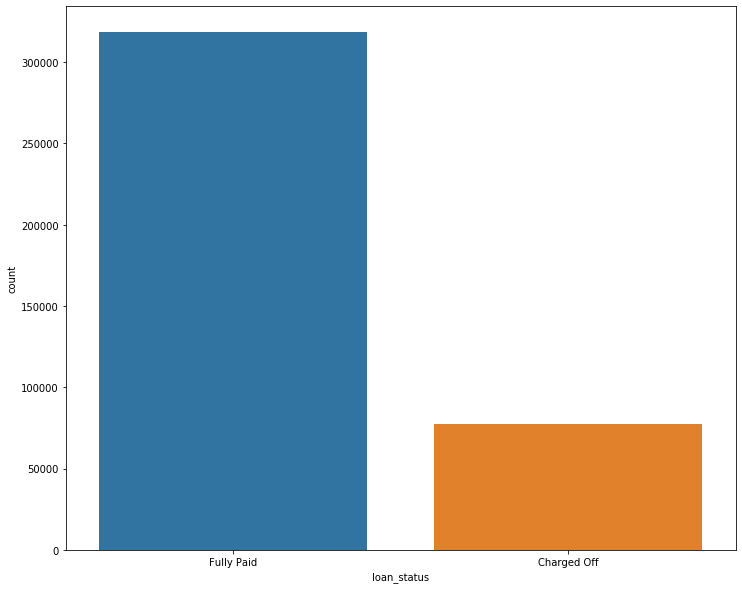

In [134]:
plt.figure(figsize=(12,10))
sns.countplot('loan_status',data=df)

(0, 45000)

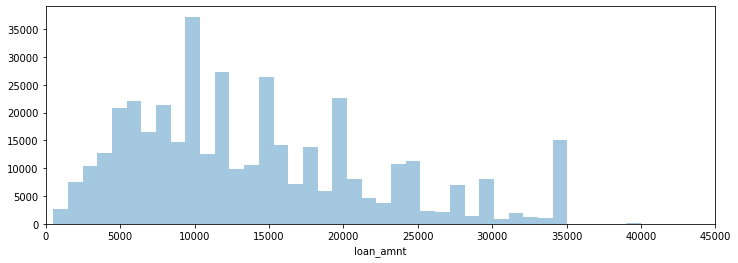

In [135]:
plt.figure(figsize=(12,4))
sns.distplot(df['loan_amnt'],kde=False,bins=40)
plt.xlim(0,45000)

(10, 0)

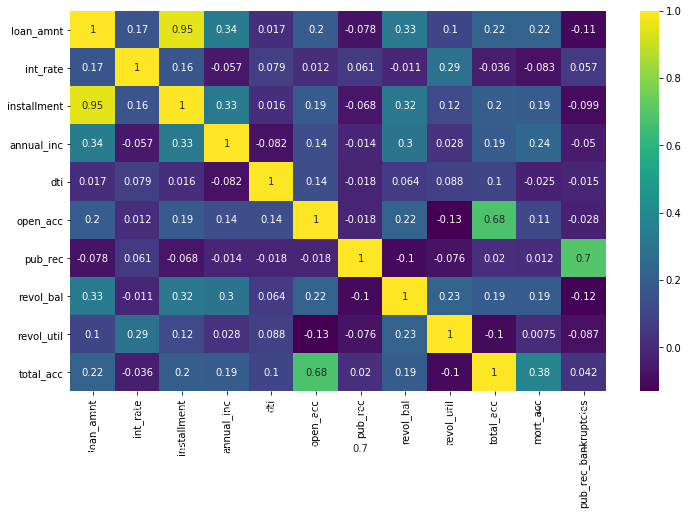

In [136]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),annot=True,cmap='viridis')
plt.ylim(10, 0)

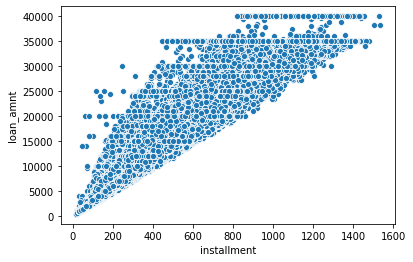

In [137]:
sns.scatterplot(x='installment',y='loan_amnt',data=df,)

In [138]:
sorted(df['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

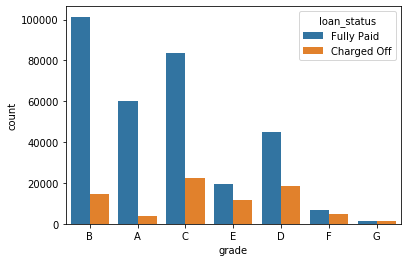

In [139]:
sns.countplot(x='grade',data=df,hue='loan_status')

In [140]:

df['term'] = df['term'].apply(lambda term: term[:3])
df['home_ownership'] = df['home_ownership'].replace(['NONE', 'ANY'],'OTHER')
df['zip_code'] = df['address'].apply(lambda address:address[-5:])
df = df.drop('address',axis=1)

In [141]:
dummies = pd.get_dummies(df[['zip_code','sub_grade','application_type','purpose', 'home_ownership','verification_status', 'initial_list_status']], drop_first=True)
df = pd.concat([df.drop(['zip_code','sub_grade','application_type','purpose', 'home_ownership','verification_status', 'initial_list_status'], axis =1), dummies], axis=1)
df = df.drop(['emp_title', 'emp_length', 'title', 'issue_d', 'earliest_cr_line', 'grade'], axis=1)
df.head()

,loan_amnt,term,int_rate,installment,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w
0,10000.0,36,11.44,329.48,117000.0,Fully Paid,26.24,16.0,0.0,36369.0,...,0,0,1,0,0,0,1,0,0,1
1,8000.0,36,11.99,265.68,65000.0,Fully Paid,22.05,17.0,0.0,20131.0,...,0,0,0,0,0,0,0,0,0,0
2,15600.0,36,10.49,506.97,43057.0,Fully Paid,12.79,13.0,0.0,11987.0,...,0,0,0,0,0,0,1,1,0,0
3,7200.0,36,6.49,220.65,54000.0,Fully Paid,2.60,6.0,0.0,5472.0,...,0,0,0,0,0,0,1,0,0,0
4,24375.0,60,17.27,609.33,55000.0,Charged Off,33.95,13.0,0.0,24584.0,...,0,0,0,0,0,0,0,0,1,0


In [142]:
mort_map = df.groupby('total_acc').mean()['mort_acc']

In [143]:

def mort_mapping(total_acc,mort_acc):
    if pd.isnull(mort_acc):
        return mort_map[total_acc]
    else:
        return mort_acc
df['mort_acc'] = df.apply(lambda x: mort_mapping(x['total_acc'], x['mort_acc']),axis=1)

In [144]:
df = df.dropna()


In [145]:
df['repaid_label'] = df['loan_status'].map({'Charged Off':0, 'Fully Paid': 1})
df = df.drop('loan_status',axis=1)

In [146]:
df.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,...,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,repaid_label
0,10000.0,36,11.44,329.48,117000.0,26.24,16.0,0.0,36369.0,41.8,...,0,1,0,0,0,1,0,0,1,1
1,8000.0,36,11.99,265.68,65000.0,22.05,17.0,0.0,20131.0,53.3,...,0,0,0,0,0,0,0,0,0,1
2,15600.0,36,10.49,506.97,43057.0,12.79,13.0,0.0,11987.0,92.2,...,0,0,0,0,0,1,1,0,0,1
3,7200.0,36,6.49,220.65,54000.0,2.60,6.0,0.0,5472.0,21.5,...,0,0,0,0,0,1,0,0,0,1
4,24375.0,60,17.27,609.33,55000.0,33.95,13.0,0.0,24584.0,69.8,...,0,0,0,0,0,0,0,1,0,0


In [147]:

y = df.pop('repaid_label').values
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [148]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# df.head()

In [149]:
X_test.shape

(79044, 77)

In [150]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw


# input layer
model.add(Dense(77,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
model.fit
model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          batch_size=128,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/600
2471/2471 [==============================] - 2s 984us/step - loss: 0.2880 - val_loss: 0.2615
Epoch 2/600
2471/2471 [==============================] - 2s 939us/step - loss: 0.2645 - val_loss: 0.2616
Epoch 3/600
2471/2471 [==============================] - 2s 862us/step - loss: 0.2626 - val_loss: 0.2599
Epoch 4/600
2471/2471 [==============================] - 2s 938us/step - loss: 0.2618 - val_loss: 0.2595
Epoch 5/600
2471/2471 [==============================] - 2s 880us/step - loss: 0.2611 - val_loss: 0.2595
Epoch 6/600
2471/2471 [==============================] - 2s 895us/step - loss: 0.2608 - val_loss: 0.2591
Epoch 7/600
2471/2471 [==============================] - 2s 892us/step - loss: 0.2603 - val_loss: 0.2593
Epoch 8/600
2471/2471 [==============================] - 2s 884us/step - loss: 0.2601 - val_loss: 0.2589
Epoch 9/600
2471/2471 [==============================] - 2s 937us/step - loss: 0.2598 - val_loss: 0.2588
Epoch 10/600
2471/2471 [==============================]

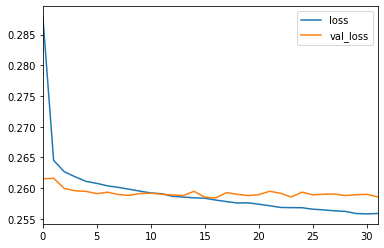

In [151]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [152]:
predictions = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [153]:
from sklearn.metrics import classification_report,confusion_matrix

In [154]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.92      0.47      0.62     15421
           1       0.88      0.99      0.93     63623

    accuracy                           0.89     79044
   macro avg       0.90      0.73      0.78     79044
weighted avg       0.89      0.89      0.87     79044

